# 2022 NFL Touchdown Regression

Siddarth Puliyanda

I will be using the 2021 NFL Player stats to see if a player scored more or less touchdowns than expected in the 2021 season.
This can help determine who overperformed or underperformed in the touchdown category for 2021 and if a player is due for a positive or negative touchdown regression for the 2022 season.

The method of analysis will be to find the average amount of touchdowns (TDs) scored for each position in 2021 and compare that to the actual amount of TDs they scored, based on that player's skill position stat (passing attempts, rushing attempts, or receptions). This is essentially expected - observed, or the residual.

The data was pulled from https://www.pro-football-reference.com/years/2021/fantasy.htm

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Import and read in data, and view the column names
df = pd.read_excel('sportsref_download (1).xlsx')[0:151] #Top 150 scoring players
display(df.head())
print(df.columns)

,Rk,Player,Tm,FantPos,Age,G,GS,Cmp,Pass_Atts,Pass_Yds,...,TD,14:00:00,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank
0,1.0,Jonathan Taylor*+,IND,RB,22.0,17.0,17.0,0.0,0.0,0.0,...,20.0,NaN,NaN,333.0,373.1,381.1,353.1,187.0,1.0,1.0
1,2.0,Cooper Kupp*+,LAR,WR,28.0,17.0,17.0,0.0,1.0,0.0,...,16.0,1.0,NaN,295.0,439.5,442.5,367.0,173.0,1.0,2.0
2,3.0,Deebo Samuel*+,SFO,WR,25.0,16.0,15.0,1.0,2.0,24.0,...,14.0,NaN,NaN,262.0,339.0,347.0,300.5,140.0,2.0,3.0
3,4.0,Josh Allen,BUF,QB,25.0,17.0,17.0,409.0,646.0,4407.0,...,6.0,2.0,1.0,403.0,402.6,426.6,417.6,134.0,1.0,4.0
4,5.0,Austin Ekeler,LAC,RB,26.0,16.0,16.0,0.0,0.0,0.0,...,20.0,2.0,NaN,274.0,343.8,352.8,308.8,128.0,2.0,5.0


Index([        'Rk',     'Player',         'Tm',    'FantPos',        'Age',
                'G',         'GS',        'Cmp',  'Pass_Atts',   'Pass_Yds',
          'Pass_TD',        'Int',   'Rush_Att',   'Rush_Yds',        'Y/A',
          'Rush_TD',        'Tgt',        'Rec',        'Yds',        'Y/R',
       'Receive_TD',        'Fmb',         'FL',         'TD',     14:00:00,
              '2PP',     'FantPt',        'PPR',       'DKPt',       'FDPt',
              'VBD',    'PosRank',     'OvRank'],
      dtype='object')


We only want to see the top 150 scoring fantasy players from 2021 because players after that are quite irrelevant. Also all players who are top 150 scorers probably played more than 5 games, which is a decent amount of games per player given there's only 17 games in a season.

## Clean and Prep Data

In [2]:
#Confirm that all players played at least 5 games
print(df.sort_values(by = ['G'], inplace = False).head(10))

#Some players have FantPos NaN (like Nick Ralston), but they will get filtered out later when we create positional dfs

        Rk               Player   Tm FantPos   Age    G   GS    Cmp  \
74    75.0         Nick Ralston  DAL     NaN  25.0  4.0  0.0    0.0   
143  144.0       Trevor Siemian  NOR      QB  30.0  6.0  4.0  108.0   
139  140.0  Christian McCaffrey  CAR      RB  25.0  7.0  7.0    0.0   
108  109.0       Jameis Winston  NOR      QB  27.0  7.0  7.0   95.0   
147  148.0           Cam Newton  CAR      QB  32.0  8.0  5.0   69.0   
144  145.0          Kareem Hunt  CLE      RB  26.0  8.0  1.0    0.0   
76    77.0          Tory Carter  TEN     NaN  22.0  8.0  2.0    0.0   
43    44.0        Derrick Henry  TEN      RB  27.0  8.0  8.0    1.0   
150  151.0       D'Onta Foreman  TEN      RB  25.0  9.0  3.0    0.0   
136  137.0         Robert Woods  LAR      WR  29.0  9.0  9.0    0.0   

     Pass_Atts  Pass_Yds  ...    TD  14:00:00  2PP  FantPt    PPR   DKPt  \
74         0.0       0.0  ...   0.0       NaN  NaN     NaN    NaN    NaN   
143      188.0    1154.0  ...   1.0       NaN  NaN    90.0   90.2 

In [3]:
# Some player names have characters at the end that we don't need (the * and +). Let's remove them.
df['Player'] = df['Player'].str.replace('*','')
df['Player'] = df['Player'].str.replace('+','')
print(df['Player'].head(10))

0     Jonathan Taylor
1         Cooper Kupp
2        Deebo Samuel
3          Josh Allen
4       Austin Ekeler
5      Justin Herbert
6           Tom Brady
7        Mark Andrews
8       Ja'Marr Chase
9    Justin Jefferson
Name: Player, dtype: object


/var/folders/m1/ttxn6nhn2s98l9q9llw88ny00000gn/T/ipykernel_59863/2754416600.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Player'] = df['Player'].str.replace('*','')
/var/folders/m1/ttxn6nhn2s98l9q9llw88ny00000gn/T/ipykernel_59863/2754416600.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Player'] = df['Player'].str.replace('+','')


Let's now create new dataframes for each position, only using the necessary statistical columns for each.
The positions will be: Quarterback (QB), Running Back (RB), Wide Receiver (WR), and Tight End (TE).

In [4]:
# Dataframe for Quarterbacks with passing stats
# Only return top 30 because we don't want QBs who barely played to affect the totals
df_qb = df[['Player','Tm','FantPos','Cmp','Pass_Atts','Pass_Yds','Pass_TD','TD','FantPt','PosRank']]
df_qb = df_qb.loc[df_qb['FantPos'] == 'QB'][:30].reset_index(drop=True)
display(df_qb.head())
display(df_qb.tail())

,Player,Tm,FantPos,Cmp,Pass_Atts,Pass_Yds,Pass_TD,TD,FantPt,PosRank
0,Josh Allen,BUF,QB,409.0,646.0,4407.0,36.0,6.0,403.0,1.0
1,Justin Herbert,LAC,QB,443.0,672.0,5014.0,38.0,3.0,381.0,2.0
2,Tom Brady,TAM,QB,485.0,719.0,5316.0,43.0,2.0,375.0,3.0
3,Patrick Mahomes,KAN,QB,436.0,658.0,4839.0,37.0,2.0,362.0,4.0
4,Aaron Rodgers,GNB,QB,366.0,531.0,4115.0,37.0,3.0,332.0,5.0


,Player,Tm,FantPos,Cmp,Pass_Atts,Pass_Yds,Pass_TD,TD,FantPt,PosRank
25,Tua Tagovailoa,MIA,QB,263.0,388.0,2653.0,16.0,3.0,181.0,25.0
26,Daniel Jones,NYG,QB,232.0,361.0,2428.0,10.0,2.0,167.0,27.0
27,Sam Darnold,CAR,QB,243.0,406.0,2527.0,9.0,5.0,157.0,28.0
28,Davis Mills,HOU,QB,263.0,394.0,2664.0,16.0,0.0,157.0,29.0
29,Zach Wilson,NYJ,QB,213.0,383.0,2334.0,9.0,4.0,152.0,30.0


One thing to note is that QBs could also have positive or negative regression for their rushing TDs. However there
are not enough rushing QBs in the league to make a fair assessment on regression.
Here's the QBs sorted by number of rushing TDs. Only 5 QBs had more than 5 rushing TDs and a majority had 2 or less.
So we will ignore rushing TD regression for QBs.

Also Sam Darnold had all 5 of his rushing TDs in the first 4 games of the season, so he is clearly an outlier.

In [5]:
display(df_qb[['Player','Tm','FantPos','TD']].sort_values('TD', ascending = False).reset_index(drop = True))

,Player,Tm,FantPos,TD
0,Jalen Hurts,PHI,QB,10.0
1,Ryan Tannehill,TEN,QB,7.0
2,Josh Allen,BUF,QB,6.0
3,Sam Darnold,CAR,QB,5.0
4,Kyler Murray,ARI,QB,5.0
5,Zach Wilson,NYJ,QB,4.0
6,Aaron Rodgers,GNB,QB,3.0
7,Tua Tagovailoa,MIA,QB,3.0
8,Justin Herbert,LAC,QB,3.0
9,Jimmy Garoppolo,SFO,QB,3.0


In [6]:
#Dataframe for Running Backs with rushing stats
df_rb = df[['Player','Tm','FantPos','Rush_Att','Rush_Yds','Rush_TD','FantPt','PosRank']]
df_rb = df_rb.loc[df_rb['FantPos'] == 'RB'].reset_index(drop=True)
df_rb.head()

,Player,Tm,FantPos,Rush_Att,Rush_Yds,Rush_TD,FantPt,PosRank
0,Jonathan Taylor,IND,RB,332.0,1811.0,18.0,333.0,1.0
1,Austin Ekeler,LAC,RB,206.0,911.0,12.0,274.0,2.0
2,Joe Mixon,CIN,RB,292.0,1205.0,13.0,246.0,3.0
3,Najee Harris,PIT,RB,307.0,1200.0,7.0,227.0,4.0
4,James Conner,ARI,RB,202.0,752.0,15.0,221.0,5.0


In [7]:
#Dataframe for Wide Receivers with receiving stats
df_wr = df[['Player','Tm','FantPos','Tgt','Rec','Yds','Receive_TD','FantPt','PosRank']]
df_wr = df_wr.loc[df_wr['FantPos'] == 'WR'].reset_index(drop=True)
df_wr.head()

,Player,Tm,FantPos,Tgt,Rec,Yds,Receive_TD,FantPt,PosRank
0,Cooper Kupp,LAR,WR,191.0,145.0,1947.0,16.0,295.0,1.0
1,Deebo Samuel,SFO,WR,121.0,77.0,1405.0,6.0,262.0,2.0
2,Ja'Marr Chase,CIN,WR,128.0,81.0,1455.0,13.0,224.0,3.0
3,Justin Jefferson,MIN,WR,167.0,108.0,1616.0,10.0,222.0,4.0
4,Davante Adams,GNB,WR,169.0,123.0,1553.0,11.0,221.0,5.0


In [8]:
#Dataframe for Tight Ends with receiving stats
df_te = df[['Player','Tm','FantPos','Tgt','Rec','Yds','Receive_TD','FantPt','PosRank']]
df_te = df_te.loc[df_te['FantPos'] == 'TE'].reset_index(drop=True)
df_te.head()

,Player,Tm,FantPos,Tgt,Rec,Yds,Receive_TD,FantPt,PosRank
0,Mark Andrews,BAL,TE,153.0,107.0,1361.0,9.0,194.0,1.0
1,Travis Kelce,KAN,TE,134.0,92.0,1125.0,9.0,171.0,2.0
2,Dalton Schultz,DAL,TE,104.0,78.0,808.0,8.0,131.0,3.0
3,George Kittle,SFO,TE,94.0,71.0,910.0,6.0,127.0,4.0
4,Rob Gronkowski,TAM,TE,89.0,55.0,802.0,6.0,116.0,5.0


## Analysis

Now that we have all the dataframes for each position, let's create a function that takes a dataframe, finds the average TDs per significant stat (completions for QBs, rush attempts for RBs, or receptions for WRs or TEs), and returns a new dataframe with how much more or less points the player should have scored for the season.

I will create residual plots for given stat (pass attempt, rush attempt, reception) vs. residual (expected - observed). Players below the line overperformed in the touchdown category (and might be due for negative regression) and players above the line underperformed (and might be due for positive regression).

In [9]:
#Create function that can take any skill position's dataframe
#Note: 1 touchdown = 6 fantasy points, but 1 passing touchdown = 4 fantasy points

def avg_x_to_td(df): # x represents either pass attempts, rush attempts, or receptions based on the position
    dfnew = df.copy()
    avg_att = dfnew['Pass/Rush/Reception'].mean() #Find average number of input stat per position
    avg_td = dfnew['TD_Edit'].mean() #Find average number of TDs per position
    avg_att_to_td = avg_att/avg_td #Find average stat to TD ratio per position
    dfnew['Expected_TD'] = dfnew['Pass/Rush/Reception']/avg_att_to_td #New column for expected number of TDs in 2021
    dfnew['TD_diff'] = dfnew['Expected_TD']-dfnew['TD_Edit'] #New column for expected - observed TDs scored in 2021
    if (df['FantPos'] == 'QB').all(): #If QB passing TDs are 4 points, other positions TDs are 6 points
        dfnew['FantPt_+/-'] = dfnew['TD_diff']*4        
    else:    
        dfnew['FantPt_+/-'] = dfnew['TD_diff']*6
    dfnew['2021_New'] = dfnew['FantPt_+/-'] + dfnew['FantPt'] #Create column for expected 2021 points
    dfnew = dfnew.sort_values('FantPt_+/-', ascending = False)
    dfnew = dfnew[['PosRank','Player','Tm','FantPos','Pass/Rush/Reception','FantPt','FantPt_+/-','2021_New']].reset_index(drop = True)
    dfnew = dfnew.rename(columns = {'PosRank':'2021 Rank'}) #Observed 2021 rank that we can compare to our expected
    return dfnew

This is a general function we can use for all position, but we must rename the columns for each dataframe so they can be input into the function.

In [10]:
#Rename the columns for each position dataframe
#Create new variables for each edit so that the original dataframes aren't affected
df_qb_edit = df_qb.rename(columns = {'Pass_Atts':'Pass/Rush/Reception', 'Pass_TD': 'TD_Edit'})
df_rb_edit = df_rb.rename(columns = {'Rush_Att':'Pass/Rush/Reception', 'Rush_TD': 'TD_Edit'})
df_wr_edit = df_wr.rename(columns = {'Rec':'Pass/Rush/Reception', 'Receive_TD': 'TD_Edit'})
df_te_edit = df_te.rename(columns = {'Rec':'Pass/Rush/Reception', 'Receive_TD': 'TD_Edit'})

Now let's run the function against each position's dataframe.
We can use the data in the 'FantPt_+/-' column to make predictions about the player's 2022 performance. If their
value is high and positive they are due for a positive TD regression, and the opposite if the value is negative.

In [11]:
#Quarterbacks
qb_new = avg_x_to_td(df_qb_edit)
qb_new

,2021 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2021_New
0,23.0,Trevor Lawrence,JAX,QB,602.0,199.0,64.524829,263.524829
1,28.0,Sam Darnold,CAR,QB,406.0,157.0,39.888838,196.888838
2,30.0,Zach Wilson,NYJ,QB,383.0,152.0,35.589717,187.589717
3,27.0,Daniel Jones,NYG,QB,361.0,167.0,27.477514,194.477514
4,21.0,Ben Roethlisberger,PIT,QB,605.0,218.0,25.085584,243.085584
5,14.0,Derek Carr,LVR,QB,626.0,257.0,25.010869,282.010869
6,19.0,Matt Ryan,ATL,QB,560.0,223.0,24.674260,247.674260
7,9.0,Jalen Hurts,PHI,QB,432.0,312.0,16.748715,328.748715
8,24.0,Jared Goff,DET,QB,494.0,195.0,16.337651,211.337651
9,12.0,Ryan Tannehill,TEN,QB,531.0,268.0,15.253628,283.253628


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


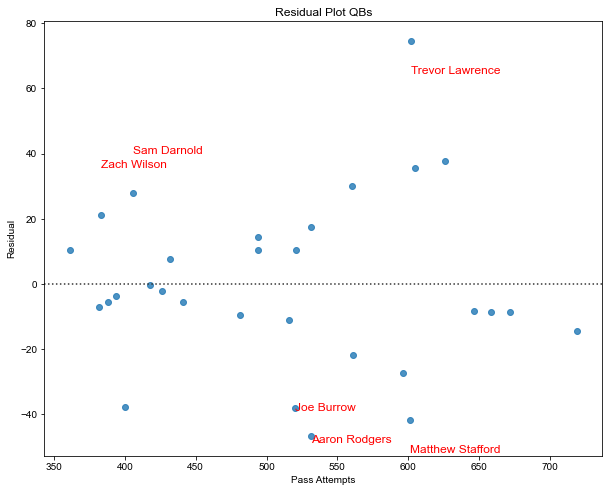

In [12]:
#Plot top and bottom 3 Quarterback names on residual plot
#Create scatterplot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['Trevor Lawrence', 'Sam Darnold', 'Zach Wilson', 'Joe Burrow', 'Aaron Rodgers','Matthew Stafford']
for player_name in notable_players:    
    player = qb_new.loc[qb_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(qb_new['Pass/Rush/Reception'], qb_new['FantPt_+/-'])
plt.title('Residual Plot QBs')
plt.xlabel('Pass Attempts')
plt.ylabel('Residual')
plt.show()

Observations:
1. We can see that Trevor Lawrence is at the top of the list. He is probably due for a positive passing TD regression since in 2021 he threw less TDs per pass attempts than the league average. This makes sense because he is a rookie and probably adjusting to the NFL level.
2. Another conclusion we can make is about Derek Carr. Not only is he due for some positive passing TD regression ranking at number 6 on the list, but his team also added one of the best Wide Receivers in the league this offseason (Davante Adams) so that should only further boost his passing TD output in 2022. 
3. It might be hard to trust the negative TD regression fully for quarterbacks at the bottom of the list, because some are known to throw lots of touchdowns every season, like Matthew Stafford, Aaron Rodgers, and Tom Brady, and we can assume they will continue to do so in the future.

In [13]:
#Running Backs
rb_new = (avg_x_to_td(df_rb_edit))
rb_new

,2021 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2021_New
0,43.0,Miles Sanders,PHI,RB,137.0,91.0,28.516574,119.516574
1,9.0,Alvin Kamara,NOR,RB,240.0,188.0,25.956041,213.956041
2,4.0,Najee Harris,PIT,RB,307.0,227.0,21.902103,248.902103
3,34.0,Saquon Barkley,NYG,RB,162.0,108.0,21.720328,129.720328
4,27.0,Sony Michel,LAR,RB,208.0,125.0,19.295236,144.295236
5,18.0,Javonte Williams,DEN,RB,203.0,162.0,18.254485,180.254485
6,35.0,Devontae Booker,NYG,RB,145.0,104.0,18.181775,122.181775
7,28.0,Myles Gaskin,MIA,RB,173.0,125.0,18.009980,143.009980
8,15.0,Dalvin Cook,MIN,RB,249.0,172.0,15.829393,187.829393
9,29.0,Tony Pollard,DAL,RB,130.0,124.0,15.059522,139.059522


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


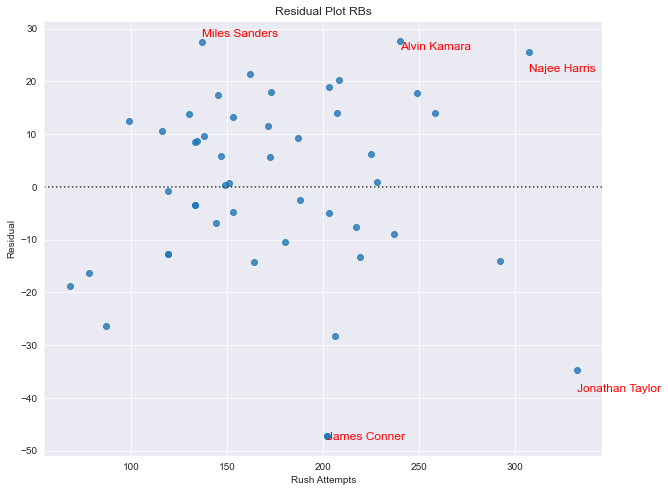

In [14]:
#Plot top and bottom 3 Running Back names on residual plot
#Create scatter plot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['Miles Sanders', 'Alvin Kamara', 'James Conner', 'Jonathan Taylor', 'Najee Harris']
for player_name in notable_players:    
    player = rb_new.loc[rb_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(rb_new['Pass/Rush/Reception'], rb_new['FantPt_+/-'], ax=ax)
plt.title('Residual Plot RBs')
plt.xlabel('Rush Attempts')
plt.ylabel('Residual')
plt.show()

Observations:
1. We can see that Miles Sanders is at the top of the list, which makes sense because he did not score a single rushing TD in 2021. However, this could be because the Philadelphia Eagles use 3 running backs, as  we can see Kenneth Gainwell and Boston Scott at the bottom on the list who took all the rushing TDs. Also, the Eagles QB is Jalen Hurts, who from the earlier table we can see lead the league in rushing TDs for QBs. So although Miles Sanders is at the top of the list, he might not be due for the positive rushing TD regression in 2022 that we might expect.
2. However the other 2 RBs at the top of the list, Alvin Kamara and Najee Harris, are very interesting. We can see that both of these players ranked 9th and 4th overall for RBs in 2021 respectively (looking at the 2021 Rank column). Their situations look very ideal for some positive TD regression because they are both the main players on their team and don't seem to have any other outside factors that could limit their rushing TDs in 2022.
3. At the very bottom of the list, we have James Conner. Although he scored much more TDs than expected in 2021, he may continue to see this high volume of TDs because the Arizona Cardinals traded their other main RB in 2021 to a different team (Chase Edmonds). So again the data needs to be looked at holistically to create the best conclusions. (Interestingly enough, Damien Harris and James Conner have the exact same residual score and are tied in the regression rankings)

In [15]:
#Wide Receivers
wr_new = (avg_x_to_td(df_wr_edit))
wr_new

,2021 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2021_New
0,41.0,Jakobi Meyers,NWE,WR,83.0,103.0,32.266667,135.266667
1,18.0,D.J. Moore,CAR,WR,93.0,145.0,25.600000,170.600000
2,19.0,Chris Godwin,TAM,WR,98.0,144.0,22.266667,166.266667
3,15.0,Keenan Allen,LAC,WR,106.0,152.0,20.533333,172.533333
4,36.0,Chase Claypool,PIT,WR,59.0,108.0,19.466667,127.466667
5,21.0,Jaylen Waddle,MIA,WR,104.0,142.0,19.466667,161.466667
6,22.0,Darnell Mooney,CHI,WR,81.0,139.0,19.200000,158.200000
7,47.0,Courtland Sutton,DEN,WR,58.0,92.0,18.933333,110.933333
8,23.0,Amon-Ra St. Brown,DET,WR,90.0,137.0,18.000000,155.000000
9,37.0,Marvin Jones,JAX,WR,73.0,107.0,14.933333,121.933333


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


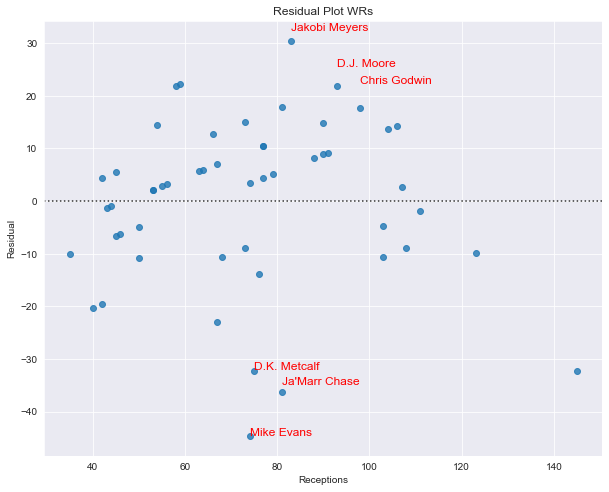

In [16]:
#Plot top and bottom 3 Wide Receiver names on residual plot
#Create scatterplot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['Jakobi Meyers','D.J. Moore','Chris Godwin','D.K. Metcalf',"Ja'Marr Chase",'Mike Evans']
for player_name in notable_players:    
    player = wr_new.loc[wr_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(wr_new['Pass/Rush/Reception'], wr_new['FantPt_+/-'])
plt.title('Residual Plot WRs')
plt.xlabel('Receptions')
plt.ylabel('Residual')
plt.show()

Observations:

- Wide receivers are interesting because their receiving touchdowns are directly affected by the QB who is throwing the ball. For example, we have D.J. Moore second on the list. His QB situation for the 2021 was very rocky, as they had 3 different starting QBs for the season, all of whom did not play expectionally well. So although he is at the top of the list, unless his QB situation becomes more steady I would not trust that his receiving TDs will positively regress in 2022.

- Here are 2 situations for different players that I can see that are complete opposites, but interesting points of discussion.

1. Jaylen Waddle is 6th on the list, however the Miami Dolphins traded for one of the best WRs in the NFL with Tyreek Hill. So though Jaylen Waddle could be due for some positive TD regression, Tyreek Hill might take some of that away.
2. On the other hand, CeeDee Lamb is in the middle of the list at #18 with a FantPt +/- score of 6.133. Though this number is not very high, the Dallas Cowboys traded 2 of their WRs, Amari Cooper and Cedrick Wilson Jr., both of whom are near the bottom of the list (meaning they overperformed in the TD category). This could fair well for CeeDee as he can get more receiving TDs with the other players gone from the team.

In [17]:
#Tight Ends
te_new = (avg_x_to_td(df_te_edit))
te_new

,2021 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2021_New
0,9.0,Kyle Pitts,ATL,TE,68.0,109.0,29.625780,138.625780
1,11.0,Mike Gesicki,MIA,TE,73.0,92.0,26.245322,118.245322
2,13.0,Noah Fant,DEN,TE,68.0,91.0,11.625780,102.625780
3,10.0,Zach Ertz,2TM,TE,74.0,107.0,8.769231,115.769231
4,8.0,Dallas Goedert,PHI,TE,56.0,109.0,5.338877,114.338877
5,1.0,Mark Andrews,BAL,TE,107.0,194.0,2.058212,196.058212
6,14.0,Tyler Higbee,LAR,TE,61.0,86.0,1.958420,87.958420
7,4.0,George Kittle,SFO,TE,71.0,127.0,1.197505,128.197505
8,2.0,Travis Kelce,KAN,TE,92.0,171.0,-5.800416,165.199584
9,3.0,Dalton Schultz,DAL,TE,78.0,131.0,-7.135135,123.864865


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


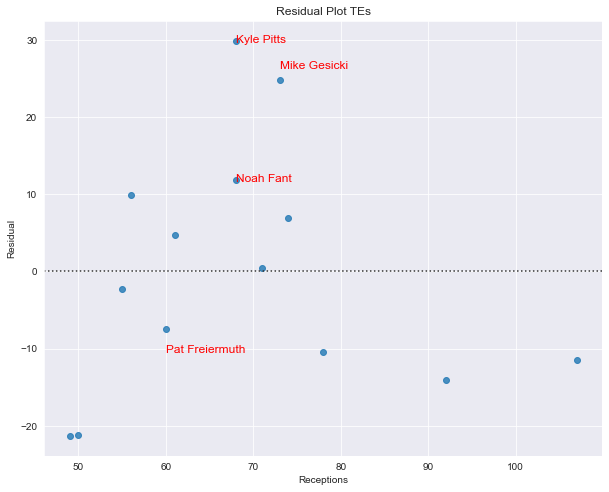

In [18]:
#Plot top and bottom 3 Tight End names on residual plot
#Create scatterplot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['Kyle Pitts','Mike Gesicki','Noah Fant','Pat Freiermuth','Hunter Henry','Dawson Knox']
for player_name in notable_players:    
    player = te_new.loc[te_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(te_new['Pass/Rush/Reception'], te_new['FantPt_+/-'])
plt.title('Residual Plot TEs')
plt.xlabel('Receptions')
plt.ylabel('Residual')
plt.show()

Observations:

1. First thing to note is that there are only 14 TEs on this list, which makes sense since there are so few good and consistent TEs in the NFL.
2. At the top of the list is Kyle Pitts, who is likely due for a positive TD regression in 2022 as he only had 1 TD for his 68 receptions. However, the Atlanta Falcons traded their starting QB and got a new one for the 2022 season so it would be best to proceed with caution when judging him.
3. At the bottom of the list is Dawson Knox, who is likely due for a negative TD regression as he scored significantly more TDs than expected in 2021.

## Conclusions

- The TD regression won't tell the full story of how well we think a player will do in 2022 as there are many outside factors that can contribute to success, such as overall talent, trading for/away players, and who each team drafts in the 2022 NFL Draft.

- It is better to view the data holistically with all other factors that go into fantasy football production. But this can help us determine which players we might want to target in the Fantasy Draft for the 2022 season. It is also important to actually watch the games and keep up with the NFL, instead of solely relying on the data. For example, Sam Darnold and Daniel Jones are 2nd and 4th on the list for QB passing TD regression. However they are both horrible players with bad situations so I would not expect a positive TD regression next season.

- The model takes into account the number of pass attempts, rushing attempts, and receptions, which is important to include because it can determine a player's usage as well. By looking at the residual plots, we can see how much a player was used in the offense and how their fantasy output might have changed (for better or worse) after applying the touchdown regression. The further a player is away from the middle line of the graph, the more regression they might be due for. Ideally, we would target players that have a high usage.

- If you want to use this data to help with a Fantasy Football Draft in 2022, you can also sort the values in the 2021_New column in descending order to find the expected rankings of each player in 2021. I would likely target players who not only finished high on the rankings in 2021, but are also due for some positive TD regression (such as Trevor Lawrence, Alvin Kamara, Najee Harris, Jakobi Meyers, Kyle Pitts)

- We will not be able to tell if our conclusions were accurate until the end of the 2022 season, but it will be useful to compare our conclusions to the actual results.